# Strategy details

Reference: X. Guo, H. Dong, and G. A. Patterson, Equity Returns Around Extreme Loss: A Stochastic Event Approach, American Business Review, May 2024, Vol.27(1) 207 – 220

The idea is that extreme loss events will be recovered. Extreme loss events are examined, defined as negative returns lower than 97.5% of an asset's daily returns.

I will do it in both time series and cross sectional way to see if the idea is tradable.

In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from multiprocessing import Pool

symbols_dir = "../Symbols.csv"
symbols = pd.read_csv(symbols_dir, index_col=0)
russel = symbols["US-Equity-Russell-2000"].dropna().values.tolist()
snp = symbols["US-Equity-SNP"].dropna().values.tolist()

In [74]:
# Load the data
def download_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')
    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-5-31')
        df.to_csv(file_name)

for i, symbol in enumerate(russel + snp):
    print (f'Loading data for {symbol} ({i+1}/{len(russel+snp)})', end='\r')
    download_data(symbol)

print (f'Loaded data for {len(russel+snp)} companies')

Loaded data for 2351 companies1)))


In [75]:
def process_data(symbol):

    df = pd.read_csv(f'data/{symbol}.csv', index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')

    df = df[['Open', 'Close']].copy()

    # We get the signal after we get the daily close, then, we will be able to
    # trade the next day at open. But, I am keeping the today's close for
    # research and analysis purposes.
    df['next_5d_return_with_next_day_open'] = df['Close'].shift(-5) / df['Open'].shift(-1) - 1
    df['next_5d_return_with_today_close'] = df['Close'].shift(-5) / df['Close'] - 1

    df['return'] = df['Close'].pct_change()
    df['zscore_22d'] = (df['return'] - df['return'].rolling(22).mean()) / df['return'].rolling(22).std()
    df['zscore_66d'] = (df['return'] - df['return'].rolling(66).mean()) / df['return'].rolling(66).std()

    return df

with Pool(os.cpu_count()-2) as p:
    russel_data = p.map(process_data, russel)

with Pool(os.cpu_count()-2) as p:
    snp_data = p.map(process_data, snp)

In [76]:
holder_for_regression = []
for symbol, df in zip(russel, russel_data):
    df = df.dropna().copy()
    df['ticker'] = symbol
    df['index'] = 'russel'
    holder_for_regression.append(df)

for symbol, df in zip(snp, snp_data):
    df = df.dropna().copy()
    df['ticker'] = symbol
    df['index'] = 'snp'
    holder_for_regression.append(df)

df_for_regression = pd.concat(holder_for_regression, axis=0)

X_col = 'zscore_66d'

# Keep the rows with zscore of less than -2
df_for_regression = df_for_regression[df_for_regression[X_col] < -2]

# Drop any next_5d_return_with_next_day_open that over 200%, as outliers
df_for_regression = df_for_regression[df_for_regression['next_5d_return_with_next_day_open'] < 2]

# Run the regression
X = df_for_regression[X_col]
X = sm.add_constant(X)
y = df_for_regression['next_5d_return_with_next_day_open']

model = sm.OLS(y, X)

results = model.fit()
print(results.summary())

                                    OLS Regression Results                                   
Dep. Variable:     next_5d_return_with_next_day_open   R-squared:                       0.002
Model:                                           OLS   Adj. R-squared:                  0.002
Method:                                Least Squares   F-statistic:                     299.6
Date:                               Wed, 05 Jun 2024   Prob (F-statistic):           4.42e-67
Time:                                       00:32:44   Log-Likelihood:             1.8890e+05
No. Observations:                             195501   AIC:                        -3.778e+05
Df Residuals:                                 195499   BIC:                        -3.778e+05
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

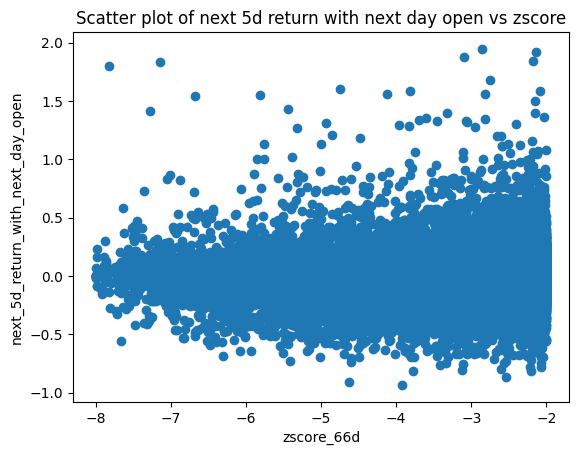

In [77]:
plt.scatter(df_for_regression[X_col], df_for_regression['next_5d_return_with_next_day_open'])
plt.xlabel(X_col)
plt.ylabel('next_5d_return_with_next_day_open')
plt.title('Scatter plot of next 5d return with next day open vs zscore')
plt.show()

## Analysis of the results

Based on the p-value, we can see that we have a statistically significant factor.
But in this table, the "const" is more important. The const is quite huge with a
statistically significant p-value. These results support the findings of the paper.

Let's see if we can get something out of it.

0.003187033158079629PRST (1857/1857))


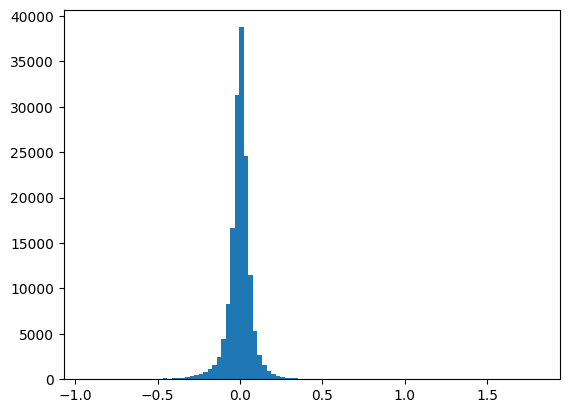

In [78]:
zscore_holder = []
next_5d_return_holder = []
price_holder = []

for i, df in enumerate(snp_data):
    print (f'Processing data for {snp[i]} ({i+1}/{len(snp)})', end='\r')
    price_holder.append(df['Close'].shift(1))
    zscore_holder.append(df['zscore_66d'])
    next_5d_return_holder.append(df['next_5d_return_with_next_day_open'])

for i, df in enumerate(russel_data):
    print (f'Processing data for {russel[i]} ({i+1}/{len(russel)})', end='\r')
    price_holder.append(df['Close'].shift(1))
    zscore_holder.append(df['zscore_66d'])
    next_5d_return_holder.append(df['next_5d_return_with_next_day_open'])

price_df = pd.concat(price_holder, axis=1)
zscore_df = pd.concat(zscore_holder, axis=1)
next_5d_return_df = pd.concat(next_5d_return_holder, axis=1)

price_df.columns = russel + snp
zscore_df.columns = russel + snp
next_5d_return_df.columns = russel + snp

# I'm filtering the data to only include the data where the price is greater than 10
# This is to avoid penny stocks and large transactions costs
price_condition = price_df > 10

# I'm filtering the data to only include the data where the next 5d return is less than 2
# This is to avoid outliers
next_5d_return_df_less_than_2 = next_5d_return_df < 2

# I'm filtering the data to only include the data where the zscore is less than -2
# This is the definition of an extreme event based on the paper.
extreme_loss_events = zscore_df < -2

zscore_df = zscore_df[
    price_condition &
    next_5d_return_df_less_than_2 &
    extreme_loss_events
]

# Let's see how the next 5d return is distributed when the zscore is less than -2
next_5d_return_df = next_5d_return_df[zscore_df.notnull()]

# Print the mean of the next 5d return
print (next_5d_return_df.mean(axis=1, skipna=True).mean())

plt.hist(next_5d_return_df.values.flatten(), bins=100)
plt.show()

1.2932968055131233


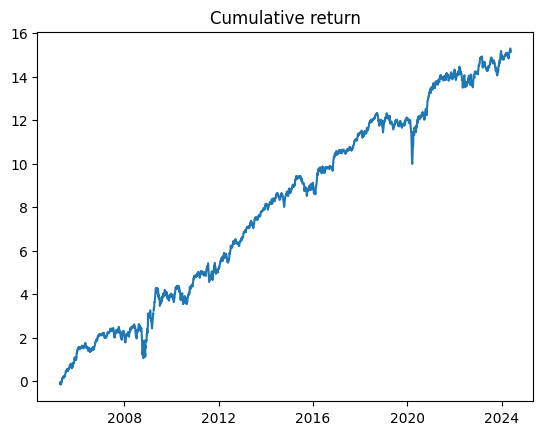

In [79]:
portfolio_return = next_5d_return_df.mean(axis=1, skipna=True)
# Because the holding period is 5 days, we assume we split the money into 5 parts
# And each day we buy the stocks that have the zscore less than -2. We will hold
# them for 5 days and then sell them. With the other parts, we will buy the stocks
# that have the zscore less than -2 on the next day. We will do this for 5 days
# Each day represents a new portfolio

# Sharpe ratio
sharpe_ratio = portfolio_return.mean() / portfolio_return.std() * np.sqrt(252)
print (sharpe_ratio)

cumsum = portfolio_return.cumsum()

plt.plot(cumsum)
plt.title('Cumulative return')
plt.show()

#### Analysis of the results

The sharpe ratio is quite large. The most obvious thing that's missing here is
the transaction costs. Based on my personal experience, transaction costs can
reduce the sharpe to 0.6-0.7, but still a good signal.

#### What is the biggest problem in this strategy?
This signal is a great example of survival bias. We are simulating a market that
has been growing for years, and on tickers that have survived. There's a huge bias
that needs to be handled.

Also, the signal is subject to market risk. A good thing to do would be hedging
against the market.